Using device: mps

=== Interpolating for SAC on Hopper-v5 ===
Seed 0: Average Return = 321.63
Seed 1: Average Return = 772.53
Seed 2: Average Return = 1779.94
Interpolating between Seed 0 and Seed 1


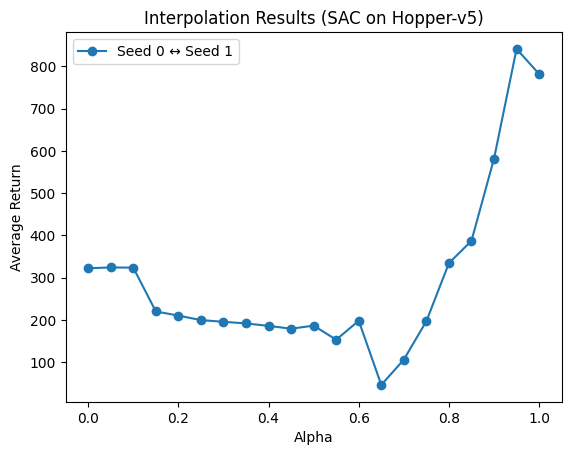

Interpolating between Seed 0 and Seed 2


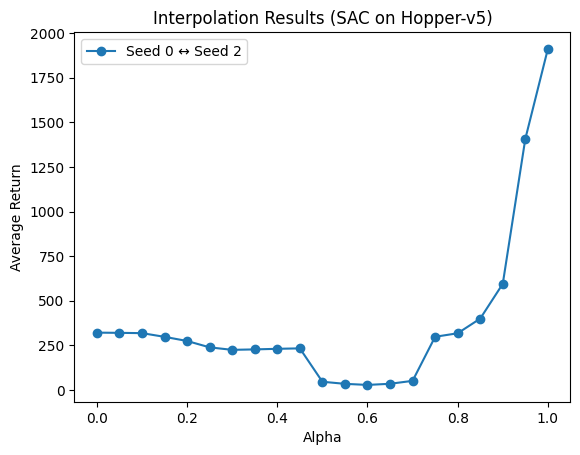

Interpolating between Seed 1 and Seed 2


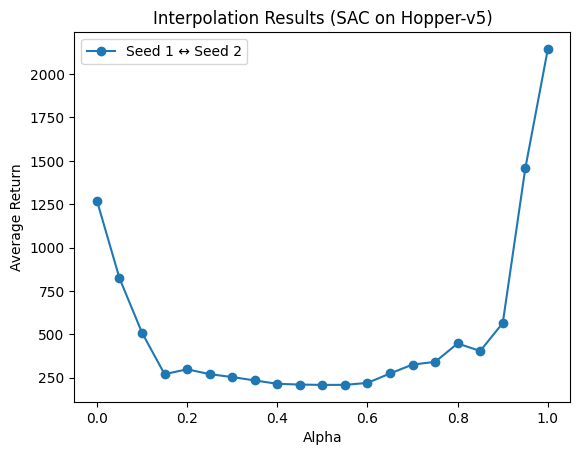


=== Interpolating for DDPG on Hopper-v5 ===
Seed 0: Average Return = 242.68
Seed 1: Average Return = 192.98
Seed 2: Average Return = 183.55
Interpolating between Seed 0 and Seed 1


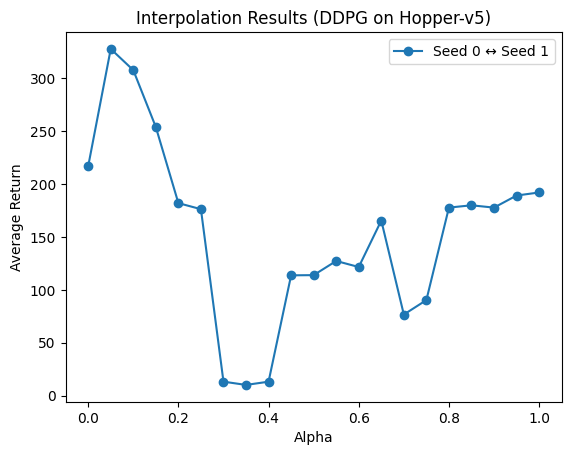

Interpolating between Seed 0 and Seed 2


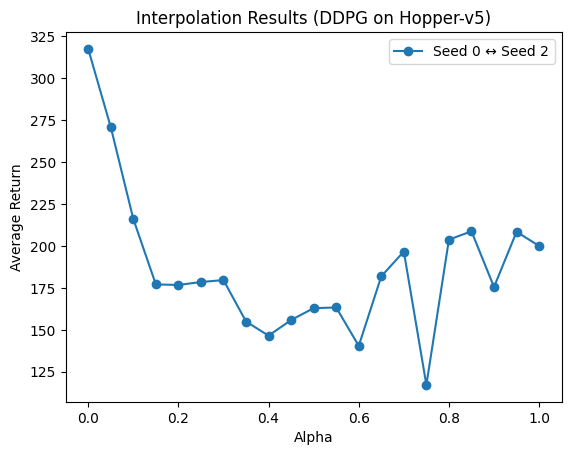

Interpolating between Seed 1 and Seed 2


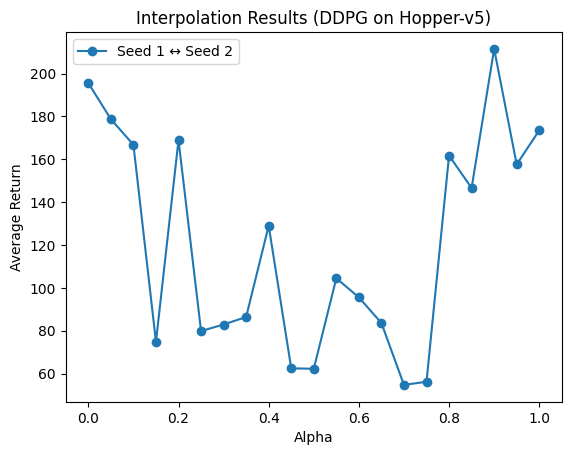


=== Interpolating for SAC on InvertedDoublePendulum-v5 ===
Seed 0: Average Return = 74.57
Seed 1: Average Return = 77.24
Seed 2: Average Return = 47.53
Interpolating between Seed 0 and Seed 1


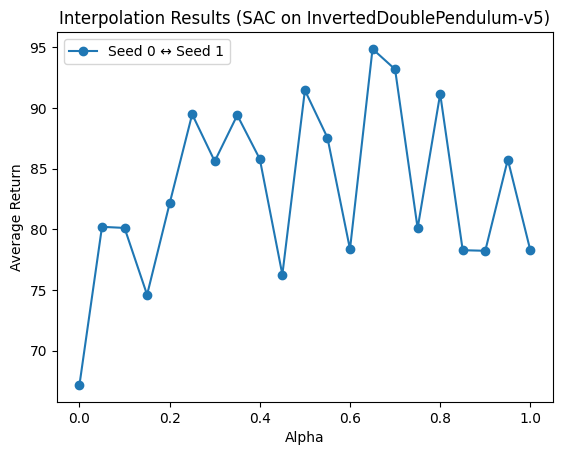

Interpolating between Seed 0 and Seed 2


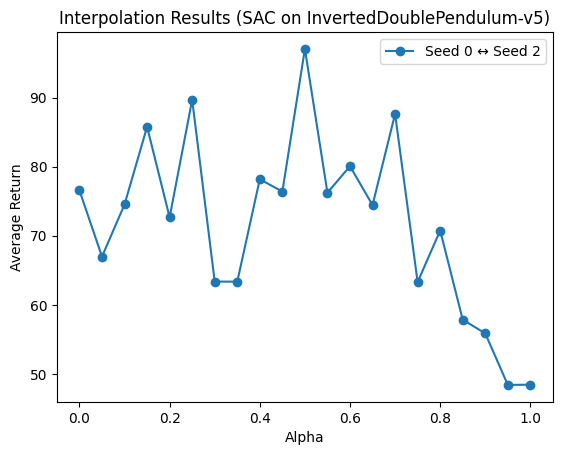

Interpolating between Seed 1 and Seed 2


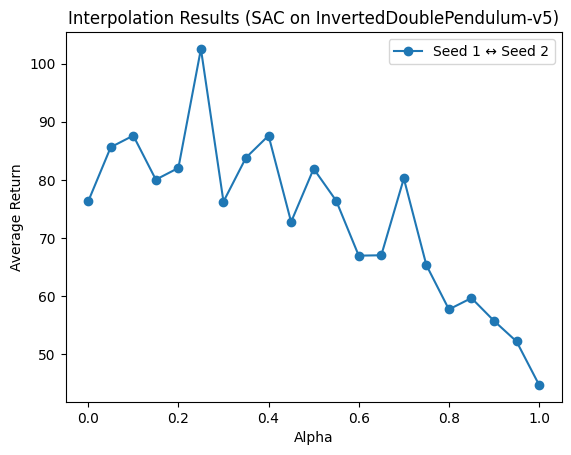


=== Interpolating for DDPG on InvertedDoublePendulum-v5 ===
Seed 0: Average Return = 89.58
Seed 1: Average Return = 82.01
Seed 2: Average Return = 69.83
Interpolating between Seed 0 and Seed 1


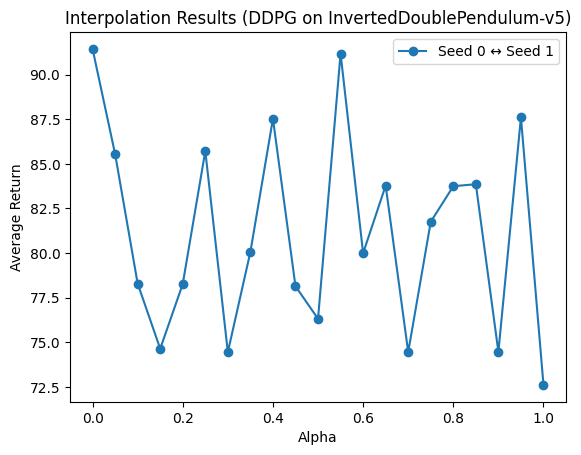

Interpolating between Seed 0 and Seed 2


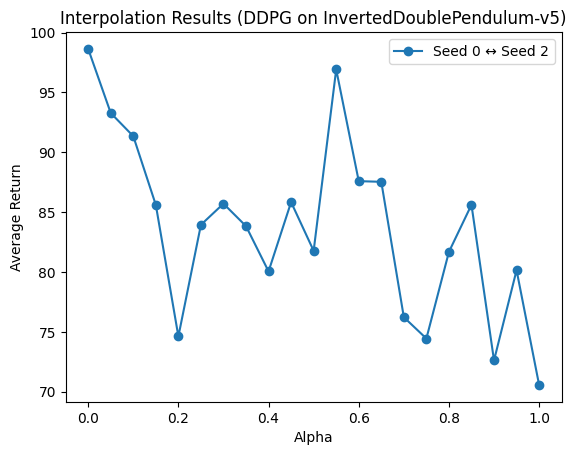

Interpolating between Seed 1 and Seed 2


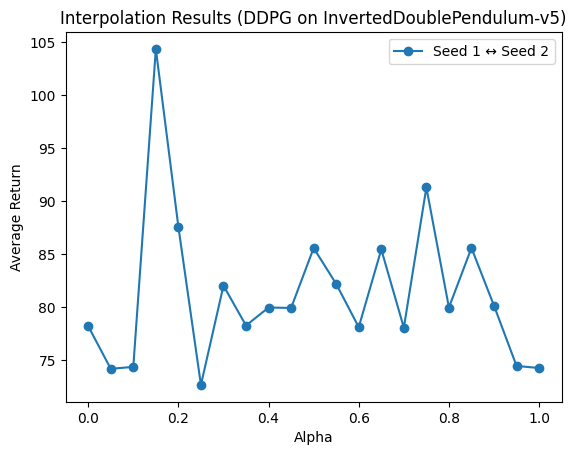

In [ ]:
import torch
import os
from core.evaluate import interpolate_policy, evaluate_policy
from agents.sac import SACAgent
from agents.ddpg import DDPGAgent
from agents.networks import ActorSAC, ActorDDPG
import gymnasium as gym
import matplotlib.pyplot as plt

# Define paths and configurations
model_dir = "model_weights/check_run (old, perhaps too short or too long)"
env_names = ["Hopper-v5", "InvertedDoublePendulum-v5"]
algos = {"SAC": SACAgent, "DDPG": DDPGAgent}
seeds = [0, 1, 2]
alphas = [i * 0.05 for i in range(21)]  # 0.0 to 1.0 in steps of 0.05

# Iterate over environments and algorithms
for env_name in env_names:
    env = gym.make(env_name)
    for algo_name, agent_class in algos.items():
        print(f"\n=== Interpolating for {algo_name} on {env_name} ===")
        
        # Load models for different seeds
        models = []
        for seed in seeds:
            model_path = os.path.join(model_dir, f"{algo_name}Agent_{env_name}_seed{seed}.pt")
            checkpoint = torch.load(model_path, map_location='cpu')
            if algo_name == "SAC":
                actor = ActorSAC(env.observation_space.shape[0], env.action_space.shape[0])
            else:  # DDPG
                actor = ActorDDPG(env.observation_space.shape[0], env.action_space.shape[0])
            actor.load_state_dict(checkpoint['actor'])
            models.append(actor)

        # Evaluate each seed ~10 times and print average return
        
        for seed, model in enumerate(models):
            avg_return = evaluate_policy(model, env, episodes=10)
            print(f"Seed {seed}: Average Return = {avg_return:.2f}")

        # Interpolate between models and evaluate
        for i in range(len(models)):
            for j in range(i + 1, len(models)):
                print(f"Interpolating between Seed {i} and Seed {j}")
                interpolation_results = []
                for alpha in alphas:
                    interpolated_actor = interpolate_policy(models[i], models[j], alpha)
                    avg_return = evaluate_policy(interpolated_actor, env, episodes=5)
                    interpolation_results.append((alpha, avg_return))
                    # print(f"Alpha {alpha:.2f}: Average Return = {avg_return:.2f}")

                # Graph the interpolation results
                alphas, returns = zip(*interpolation_results)
                plt.figure()
                plt.plot(alphas, returns, marker='o', label=f"Seed {i} ↔ Seed {j}")
                plt.title(f"Interpolation Results ({algo_name} on {env_name})")
                plt.xlabel("Alpha")
                plt.ylabel("Average Return")
                plt.legend()
                plt.show()  # Display the plot instead of saving it

        env.close()